## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [2]:
import copy
from datetime import datetime
from FireSimulator import *
from FireSimulatorUtilities import *
import glob
import itertools
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys
import time
import timeit

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

## Utility functions

In [3]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() 
        return x.view(N, -1)

## Reward function

In [4]:
def eelfff_reward(traj, img_st, center, close_pos, id_compare):
    reward = 0
    fire_neigh = [(-1,0),(0,-1),(1,0),(0,1)]
    move_neigh = [(-1,0),(1,0),(-1,1),(0,1),(1,1),(-1,-1),(0,-1),(1,-1)] #excluded (0,0)
    img_dim = img_st.shape[0]
    
    x1,y1 = traj[0]
    x2,y2 = traj[1]
    
    r = -y2 + y1 + img_dim//2
    c =  x2 - x1 + img_dim//2
    
    if img_st[r,c] in [1]:
        counter = 0
        for (dr,dc) in fire_neigh:
            rn = r + dr
            cn = c + dc
            if img_st[rn,cn]==0:
                counter += 1

        if counter > 0:
            reward += 1
        else:
            reward += -2
            
    elif img_st[r,c] in [0]:
        counter = 0
        for (dr,dc) in move_neigh:
            rn = r + dr
            cn = c + dc
            if img_st[rn,cn] in [1,2]:
                counter += 1
            
        if counter > 0:
            reward += 0.5
        else:
            reward += -1
            
    #if np.linalg.norm(cir_pos-close_pos,2)<=1 and agent_id > close_agent_id:
    if id_compare and np.linalg.norm(traj[1]-close_pos,2)<=1: 
        reward += -10
    elif id_compare and np.linalg.norm(traj[0]-close_pos,2)<=1 and np.linalg.norm(traj[1]-close_pos,2)>1:
        reward += 1
            
    move_vec = np.array([x2-x1,y2-y1])
    if (x2-x1) != 0 and (y2-y1) != 0:
        move_vec = move_vec / np.linalg.norm(move_vec,2)
       
    cen_vec = np.array([x1-center,y1-center])
    cen_vec = cen_vec / np.linalg.norm(cen_vec,2)
    score = -1*np.cross(cen_vec,move_vec)
    
    #reward += np.max([score,0])/score + 2*np.min([score,0])
    if score >= 0:
        reward += 1
    #else:
    #    reward += -2

    return reward

## Heuristic solution
hand-tuned function to generate actions for agents

In [5]:
def heuristic(agent_id, pos, img_st, seen_fire, center, close_agent_id, close_pos):

    traj = []
    actions = []
    traj.append((pos[0],pos[1]))
    img_dim = img_st.shape[0]
    fire_neigh = [(-1,0),(0,-1),(1,0),(0,1)]
    move_neigh = [(-1,0),(1,0),(-1,1),(0,1),(1,1),(-1,-1),(0,-1),(1,-1)] #excluded (0,0)
    action_set = [4,1,2,3,5,8,7,6]
    
    dists = None
    x,y = pos

    r = img_dim//2
    c = img_dim//2

    if img_st[r,c] in [1,2] or seen_fire:
        seen_fire = True
        dists = []
        
        cen_vec = np.array([x-center,y-center])
        cen_vec = cen_vec/np.linalg.norm(cen_vec)
        for a in range(1,9):
        #for a in [2,5,7,4]:
            new_pos = actions_to_trajectory(traj[-1],[a])[1]

            rl = -new_pos[1] + y + img_dim//2
            cl = new_pos[0] -x + img_dim//2
            #if a in [1,3,8,6] and img_st[rl,cl] in [0]:
            #    continue

            move_vec = np.array([new_pos[0]-x,new_pos[1]-y])
            if a != 0:
                move_vec = move_vec/np.linalg.norm(move_vec)
            dists.append((np.cross(cen_vec,move_vec),new_pos,a))

        cir_pos = min(dists)[1]
        cir_act = min(dists)[2]

        ri = -cir_pos[1] + y + img_dim//2
        ci = cir_pos[0] -x + img_dim//2

        left_act = None
        if cir_act==1:
            left_act = [6,4]
            #left_act = [4]
            righ_act = [2]
        elif cir_act==2:
            left_act = [4,1]
            #left_act = [1]
            righ_act = [3]
        elif cir_act==3:
            left_act = [1,2]
            #left_act = [2]
            righ_act = [5]
        elif cir_act==5:
            left_act = [2,3]
            #left_act = [3]
            righ_act = [8]
        elif cir_act==8:
            left_act = [3,5]
            #left_act = [5]
            righ_act = [7]
        elif cir_act==7:
            left_act = [5,8]
            #left_act = [8]
            righ_act = [6]
        elif cir_act==6:
            left_act = [8,7]
            #left_act = [7]
            righ_act = [4]
        elif cir_act==4:
            left_act = [7,6]
            #left_act = [6]
            righ_act = [1]

        out = False
        for a in left_act:
            new_pos = actions_to_trajectory(traj[-1],[a])[1]
            ro = -new_pos[1] + y + img_dim//2
            co = new_pos[0] - x + img_dim//2
            if img_st[ro,co] in [1]:
                cir_pos = new_pos
                cir_act = a
                out = True
                break

        if not out:
            for a in left_act:
                new_pos = actions_to_trajectory(traj[-1],[a])[1]
                ro = -new_pos[1] + y + img_dim//2
                co = new_pos[0] - x + img_dim//2
                if img_st[ro,co] in [2]:
                    cir_pos = new_pos
                    cir_act = a
                    out = True
                    break

        counter = 0
        for (dr,dc) in move_neigh:
            rn = ri + dr
            cn = ci + dc
            if rn>=0 and rn<img_dim and cn>=0 and cn<img_dim and img_st[rn,cn] in [0]:
                counter += 1

        if not out and img_st[ri,ci] in [0] and counter>=6:
            for a in righ_act:
                new_pos = actions_to_trajectory(traj[-1],[a])[1]
                cir_pos = new_pos
                cir_act = a

        if np.linalg.norm(cir_pos-close_pos,2)<=1 and agent_id > close_agent_id:
            cir_pos = traj[-1]
            cir_act = 0

        traj.append(cir_pos)
        actions.append(cir_act)      

    if not seen_fire:
        dists = []
        #for a in range(9):
        for idx,a in enumerate([2,5,7,4,1,3,8,6]):
            new_pos = actions_to_trajectory(traj[-1],[a])[1]
            incntv = -(8-idx)*0.1
            dists.append((np.abs(center-new_pos[0])+np.abs(center-new_pos[1])+incntv,new_pos,a))

        #print(dists)
        #print()
        score, pos, act = min(dists)
        traj.append(pos)
        actions.append(act)
        
    return traj, actions, seen_fire

## DQN architecture

In [6]:
torch.cuda.is_available()

True

In [7]:
dtype = torch.cuda.FloatTensor

In [8]:
class eelfff(nn.Module):
    
    def __init__(self, img_dim=8):
        super(eelfff, self).__init__()
        self.img_dim = img_dim
        
        # inputs: image + rot vec + id compare + pos-other_pos
        self.net = nn.Sequential(
                                nn.Linear(self.img_dim**2 + 2 + 1 + 2, 2048),
                                nn.ReLU(inplace=True),
                                nn.Linear(2048, 2048),
                                nn.ReLU(inplace=True),
                                nn.Linear(2048, 9)
                            )

    def forward(self, feat):
        return self.net(feat)


test network with random data

In [9]:
tic = time.clock()
N = 4
img_dim = 3

model = eelfff(img_dim).type(dtype)
feat = Variable(torch.randn(N,img_dim**2+2+1+2)).type(dtype)
Q = model(feat)
toc = time.clock()

print(Q.size())
print("%0.2fs = %0.2fm elapsed for this test" %(toc-tic,(toc-tic)/60))

torch.Size([4, 9])
341.04s = 5.68m elapsed for this test


## train the network

In [9]:
# simulator parameters
grid_size = 50
dp = 0.15/0.2763
repeat_ctr = 1
repeat_lim = 6
img_dim = 3
center = (grid_size+1)/2

# agent initialization parameters
spawn_loc = np.arange(grid_size//3//2,grid_size,grid_size//3)
perturbs = np.arange(-grid_size//3//2+1,grid_size//3//2+1,1)

# replay memory
memory_size = 1000000
min_exp_size = 5000
sars = None

# network instances
model = eelfff(img_dim=img_dim).type(dtype)
target = eelfff(img_dim=img_dim).type(dtype)
update_max = 6000 #6000
update_ctr = 1

# optimizer
gamma = 0.95
batch_size = 32
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# exploration
eps_init = 1
eps_finl = 0.15
anneal_range = 20000 #40000
eps = eps_init
episode_ctr = 0
episode_lim = 100

# loss function
loss_fn = nn.MSELoss(size_average=True)

# plotting data structures
rew_hist = []
loss_hist = []

pf1 = False
pf2 = False
pf3 = False

In [11]:
# optionally load a checkpoint to resume training
filename = 'simple_ext-26-Aug-2017-15:17.pth.tar'

checkpoint = torch.load(filename)
model.load_state_dict(checkpoint['state_dict'])
target.load_state_dict(checkpoint['target_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
sars = checkpoint['replay']
eps = checkpoint['epsilon']
rew_hist = checkpoint['plot_reward']
loss_hist = checkpoint['plot_loss'] 
episode_ctr = len(rew_hist)

In [12]:
seeds = range(500,610)

In [13]:
repeat_lim = 6
tic = time.clock()
# run simulator many times
for i,s in enumerate(seeds):
    np.random.seed(s)
    
    # initialize simulator
    sim = FireSimulator(grid_size, rng=s)
    sim.step([]) # start fire in domain
    
    # initialize agent position
    n = 10
    agent_pos = np.random.choice(spawn_loc, (n,2)) + np.random.choice(perturbs, (n,2))
    agent_pos = np.squeeze(agent_pos).astype(np.int32)
    agent_data = {}
    for k in range(n):
        agent_data[k] = {}
        agent_data[k]['sf'] = False
    
    seed_rew = 0
    control = []
    repeat_ctr = 1
    iter_ctr = 0
    
    new_agent_pos = np.zeros((n,2)).astype(np.int32)
    
    while not sim.end and sim.iter < 100:
        # calculate action for each agent
        for k in range(n):
            img, img_st, _ = CreateImageBW(sim.state, agent_pos[k,:])
            if img_st[8//2,8//2] in [1,2]:
                agent_data[k]['sf'] = True                
                
            rot_vec = agent_pos[k,:] - center
            rot_vec = rot_vec / np.linalg.norm(rot_vec,2)
            rot_vec = np.array([rot_vec[1],-rot_vec[0]])
            
            dists = [(np.linalg.norm(agent_pos[k,:]-p,2),j,p) for j,p in enumerate(agent_pos) if j!=k]
            min_dist, min_id, min_pos = min(dists)
            
            pos_vec = agent_pos[k,:] - min_pos
            if pos_vec[0]!=0 and pos_vec[1]!= 0:
                pos_vec = pos_vec / np.linalg.norm(pos_vec,2)
            
            state = np.concatenate((img[3:6,3:6].reshape((img_dim**2,)), rot_vec, 
                                    np.asarray(k>min_id)[np.newaxis], pos_vec))
            agent_data[k]['state'] = state
        
            # select action by exploration/exploitation
            traj = None
            action = None
            if not agent_data[k]['sf']:
                traj, action, agent_data[k]['sf'] = heuristic(k, agent_pos[k,:], img_st, 
                                                              agent_data[k]['sf'], center, min_id, min_pos)
                action = action[0]

            else:
                if np.random.rand() <= eps:
                    '''
                    if episode_ctr <= episode_lim:
                        traj, action, agent_data[k]['sf'] = heuristic(k, agent_pos[k,:], img_st, 
                                                                      agent_data[k]['sf'], center, min_id, min_pos)
                        action = action[0]
                        
                    else:
                        if not pf3:
                            pf3 = True
                            print('---DEBUG: switching over to random exploration')
                            
                        action = np.random.choice(range(9))
                        traj = actions_to_trajectory(agent_pos[k,:], [action])
                    '''
                    traj, action, agent_data[k]['sf'] = heuristic(k, agent_pos[k,:], img_st, 
                                                                  agent_data[k]['sf'], center, min_id, min_pos)
                    action = action[0]
                        
                else:   
                    state = Variable(torch.from_numpy(state)).type(dtype)
                    Q = model(state.unsqueeze(0))[0].data.cpu().numpy()
                    action = np.argmax(Q)
                    traj = actions_to_trajectory(agent_pos[k,:], [action])
                
            reward = eelfff_reward(traj, img_st, center, min_pos, k>min_id)
            agent_data[k]['action'] = action
            agent_data[k]['reward'] = reward              
                
            # generate control from trajectory
            control.extend(FindGridIntersections(sim.state, traj)) 
            control = list(set(control))
        
            # update agent location
            new_agent_pos[k,:] = [traj[-1][0], traj[-1][1]]
        
        # update simulator periodically 
        if repeat_ctr % repeat_lim == 0:
            sim.step(control, dbeta=dp)
            control = []
        repeat_ctr += 1
        
        # update agent position
        agent_pos = new_agent_pos
        new_agent_pos = np.zeros((n,2)).astype(np.int32)
        
        # don't update network when simulation terminates
        if sim.end:
            continue
            
        for k in range(n):
            if not agent_data[k]['sf']:
                continue
                
            seed_rew += agent_data[k]['reward']
            iter_ctr += 1
                
            next_img, next_img_st, _ = CreateImageBW(sim.state, agent_pos[k,:])
            if next_img_st[8//2,8//2] in [1,2]:
                agent_data[k]['sf'] = True                
                
            next_rot_vec = agent_pos[k,:] - center
            next_rot_vec = next_rot_vec / np.linalg.norm(next_rot_vec,2)
            next_rot_vec = np.array([next_rot_vec[1],-next_rot_vec[0]])
            
            dists = [(np.linalg.norm(agent_pos[k,:]-p,2),j,p) for j,p in enumerate(agent_pos) if j!=k]
            next_min_dist, next_min_id, next_min_pos = min(dists)
            
            next_pos_vec = agent_pos[k,:] - next_min_pos
            if next_pos_vec[0]!=0 and next_pos_vec[1]!= 0:
                next_pos_vec = next_pos_vec / np.linalg.norm(next_pos_vec,2)
            
            next_state = np.concatenate((next_img[3:6,3:6].reshape((img_dim**2,)), next_rot_vec, 
                                         np.asarray(k>next_min_id)[np.newaxis], next_pos_vec))
            
            if sars is None:
                sars = np.zeros((1,30))
                sars[-1,0:14] = agent_data[k]['state']
                sars[-1,14] = agent_data[k]['action']
                sars[-1,15] = agent_data[k]['reward']
                sars[-1,16:] = next_state

            else:
                data = np.zeros((1,30))
                data[-1,0:14] = agent_data[k]['state']
                data[-1,14] = agent_data[k]['action']
                data[-1,15] = agent_data[k]['reward']
                data[-1,16:] = next_state
                sars = np.vstack((sars, data))

        # skip network update if not enough experiences
        if sars is None or sars.shape[0] < min_exp_size or sars.shape[0] < batch_size:
            continue
        elif not pf1:
            pf1 = True
            print('---DEBUG: generated enough experiences')
                        
        # create a batch of experiences from memory and update network
        loss = 0
        batch = sars[np.random.choice(sars.shape[0], batch_size, replace=False), :]
        batch_states = Variable(torch.from_numpy(batch[:,0:14])).type(dtype)
        batch_actions = Variable(torch.from_numpy(batch[:,14])).type(torch.cuda.LongTensor)
        x = model(batch_states).gather(1, batch_actions.view(-1, 1)).squeeze()
        
        batch_rewards = batch[:,15]
        batch_next_states = Variable(torch.from_numpy(batch[:,16:])).type(dtype)
        tt = target(batch_next_states).data.cpu().numpy()
        tt = batch_rewards + gamma*np.amax(tt, axis=1)
        tt = Variable(torch.from_numpy(tt), requires_grad=False).type(dtype)
        loss += loss_fn(x, tt)
        
        loss_hist.append(loss.data[0])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()            
            
        # anneal exploration rate
        if eps > eps_finl:
            eps += -(eps_init - eps_finl)/anneal_range
        elif not pf2:
            pf2 = True
            print('---DEBUG: finished annealing the exploration rate')
        
        # update target network periodically
        if update_ctr % update_max == 0:
            target = copy.deepcopy(model)
            print('---DEBUG: updated target network (%d)' %(update_ctr / update_max))
        update_ctr += 1
        
        # drop from memory if too many elements
        if sars.shape[0] > memory_size:
            sars = sars[sars.shape[0]-memory_size:,:]   
                    
    rew_disp = seed_rew/n/iter_ctr
    frac_burn = sim.stats[2]/np.sum(sim.stats)
    print('seed %03d: %03d steps, %0.2f reward/agent/step, %0.4f burnt' %(s, sim.iter, rew_disp, frac_burn))
    rew_hist.append(rew_disp)
    episode_ctr += 1
    
toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

---DEBUG: generated enough experiences
seed 500: 100 steps, 0.12 reward/agent/step, 0.7944 burnt
seed 501: 100 steps, 0.12 reward/agent/step, 0.2800 burnt
seed 502: 063 steps, 0.12 reward/agent/step, 0.0312 burnt
seed 503: 100 steps, 0.10 reward/agent/step, 0.7076 burnt
seed 504: 100 steps, 0.11 reward/agent/step, 0.8628 burnt
seed 505: 051 steps, 0.11 reward/agent/step, 0.0556 burnt
seed 506: 100 steps, 0.09 reward/agent/step, 0.5572 burnt
seed 507: 027 steps, 0.08 reward/agent/step, 0.0180 burnt
seed 508: 100 steps, 0.10 reward/agent/step, 0.6088 burnt
seed 509: 094 steps, 0.10 reward/agent/step, 0.0524 burnt
seed 510: 100 steps, 0.11 reward/agent/step, 0.7432 burnt
seed 511: 033 steps, 0.09 reward/agent/step, 0.0192 burnt
seed 512: 055 steps, 0.08 reward/agent/step, 0.0196 burnt
seed 513: 047 steps, 0.09 reward/agent/step, 0.0264 burnt
---DEBUG: updated target network (1)
seed 514: 100 steps, 0.10 reward/agent/step, 0.5828 burnt
seed 515: 100 steps, 0.09 reward/agent/step, 0.1744 bu

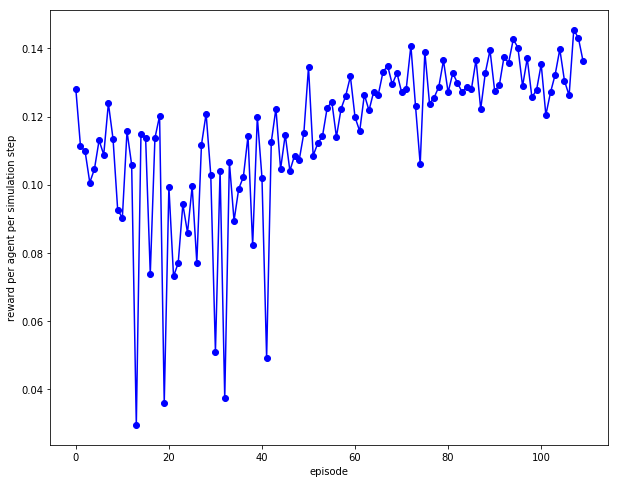

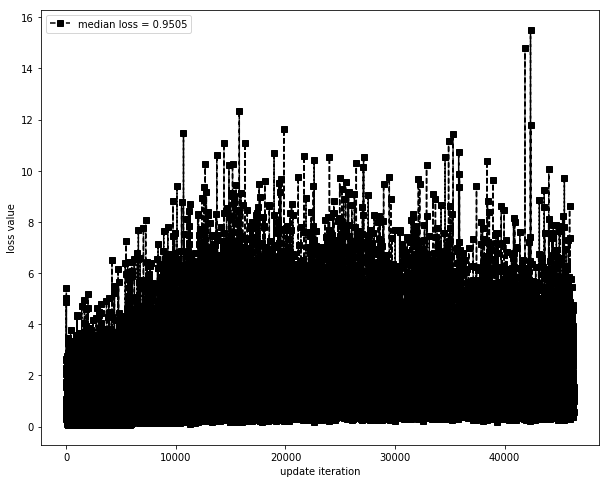

In [41]:
fig = plt.figure()
plt.plot(range(len(rew_hist)), rew_hist, 'b-o')
plt.xlabel('episode')
plt.ylabel('reward per agent per simulation step')
plt.ylabel('reward per agent per simulation step')

fig = plt.figure()
plt.plot(range(len(loss_hist)), loss_hist, 'k--s', label="median loss = %0.4f" %(np.median(loss_hist)))
plt.xlabel('update iteration')
plt.ylabel('loss value')
plt.legend()

In [42]:
Q

array([ 10.1084938 ,   6.35625601,   6.94531727,   8.08627605,
         4.85702419,  10.2519331 ,   8.06036949,   8.65294552,  10.36274052], dtype=float32)

In [43]:
episode_ctr

110

In [125]:
eps

0.14995750000063562

Save data to file - can resume training later

In [21]:
chkpt = {
    'state_dict': model.state_dict(),
    'target_dict': target.state_dict(),
    'optimizer': optimizer.state_dict(),
    'replay': sars,
    'epsilon': eps,
    'plot_reward': rew_hist,
    'plot_loss': loss_hist,
}
#filename = 'checkpoint.pth.tar'
filename = 'simple_ext-' + time.strftime('%d-%b-%Y-%H:%M') + '.pth.tar'
torch.save(chkpt, filename)

## test network in simulation

In [12]:
# seed = 603
# seed = 1
seed = 20

grid_size = 50
num_agents = 10
repeat_lim = 6

center = (grid_size+1)/2
spawn_loc = np.arange(grid_size//3//2,grid_size,grid_size//3)
perturbs = np.arange(-grid_size//3//2+1,grid_size//3//2+1,1)

seed 050: 0 reward/agent
          stats: [2484   16    0], 0.0000
0.07s = 0.00m elapsed


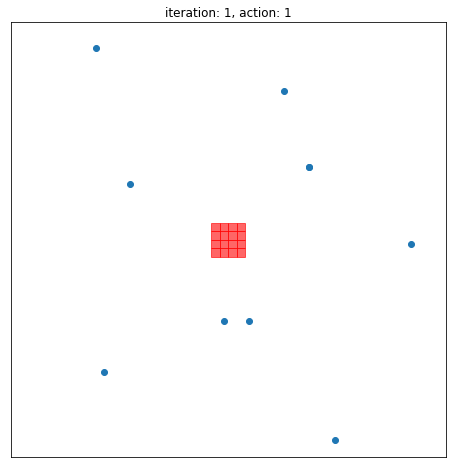

In [60]:
plotting = True
plt.close('all')

tic = time.clock()

s = seed
np.random.seed(s)

# initialize simulator
sim = FireSimulator(grid_size, rng=s)
sim.step([]) # start fire in domain

# initialize agent position
n = num_agents
agent_pos = np.random.choice(spawn_loc, (n,2)) + np.random.choice(perturbs, (n,2))
agent_pos = np.squeeze(agent_pos).astype(np.int32)
agent_data = {}
for k in range(n):
    agent_data[k] = {}
    agent_data[k]['sf'] = False

seed_rew = 0
control = []
repeat_ctr = 1

new_agent_pos = np.zeros((n,2)).astype(np.int32)

# while not sim.end:
if plotting:
    steps = 1
else:
    steps = 1000
for _ in range(steps):
    if plotting:
        fig = plt.figure()
        ax = fig.add_subplot(111, aspect='equal')
        plt.xlim([0,grid_size+1])
        plt.ylim([0,grid_size+1])
        plt.title('iteration: %d, action: %d' % (sim.iter,repeat_ctr))
        plt.tick_params(axis='both',which='both',
                        labelbottom='off',labelleft='off',
                        bottom='off',left='off')
        #plt.axis('off')

        #plt.plot(center,center,"gx")
        for i in range(grid_size):
            for j in range(grid_size):
                x = col_to_x(j)
                y = row_to_y(grid_size,i)
                #for i in range(grid_size):
                #    for j in range(grid_size):
                #        x = col_to_x(j)
                #        y = row_to_y(grid_size,i)
                #        if sim.state[i,j] == 1:
                #            plt.plot(x,y,"rs",alpha=0.6)
                #        elif sim.state[i,j] == 2:
                #            plt.plot(x,y,"ks",alpha=0.6)

                #if sim.state[i,j] == 0:
                #    rect = patches.Rectangle((x-0.5,y-0.5),1,1,alpha=0.6,color='g')
                #    ax.add_patch(rect)
                if sim.state[i,j] == 1:
                    rect = patches.Rectangle((x-0.5,y-0.5),1,1,alpha=0.6,color='r')
                    ax.add_patch(rect)
                elif sim.state[i,j] == 2:
                    rect = patches.Rectangle((x-0.5,y-0.5),1,1,alpha=0.6,color='k')         
                    ax.add_patch(rect)

    # calculate action for each agent
    for k in range(n):
        decision = None
        img, img_st, _ = CreateImageBW(sim.state, agent_pos[k,:])
        if img_st[8//2,8//2] in [1,2]:
            agent_data[k]['sf'] = True                

        rot_vec = agent_pos[k,:] - center
        rot_vec = rot_vec / np.linalg.norm(rot_vec,2)
        rot_vec = np.array([rot_vec[1],-rot_vec[0]])

        dists = [(np.linalg.norm(agent_pos[k,:]-p,2),j,p) for j,p in enumerate(agent_pos) if j!=k]
        min_dist, min_id, min_pos = min(dists)

        pos_vec = agent_pos[k,:] - min_pos
        if pos_vec[0]!=0 and pos_vec[1]!= 0:
            pos_vec = pos_vec / np.linalg.norm(pos_vec,2)

        state = np.concatenate((img[3:6,3:6].reshape((img_dim**2,)), rot_vec, 
                                np.asarray(k>min_id)[np.newaxis], pos_vec))
        

        if not agent_data[k]['sf']:
            #action = np.random.choice(range(9))
            #traj = actions_to_trajectory(agent_pos, [action])

            traj, action, agent_data[k]['sf'] = heuristic(k, agent_pos[k,:], img_st, 
                                                          agent_data[k]['sf'], center, min_id, min_pos)
            action = action[0]
            decision = 'heuristic'

        else:
            state = Variable(torch.from_numpy(state)).type(dtype)
            Q = model(state.unsqueeze(0))[0].data.cpu().numpy()
            action = np.argmax(Q)
            traj = actions_to_trajectory(agent_pos[k,:], [action])
            decision = 'network'

        reward = eelfff_reward(traj, img_st, center, min_pos, k>min_id)
        if decision == 'network':
            seed_rew += reward

        # generate control from trajectory
        control.extend(FindGridIntersections(sim.state, traj)) 
        control = list(set(control))

        # update agent location
        new_agent_pos[k,:] = [traj[-1][0], traj[-1][1]]
        
        if plotting:
            if decision == 'heuristic':
                #plt.plot(traj[0][0],traj[0][1],"C0o",label="decision = %s" % (decision))
                plt.plot(traj[0][0],traj[0][1],"C0o")
                #plt.plot(traj[-1][0],traj[-1][1],"C0^")
            else:
                #plt.plot(traj[0][0],traj[0][1],"C1o",label="decision = %s" % (decision))
                plt.plot(traj[0][0],traj[0][1],"C2o")
                #plt.plot(traj[-1][0],traj[-1][1],"C2^")              

    # update simulator periodically 
    if repeat_ctr % repeat_lim == 0:
        sim.step(control, dbeta=dp)
        control = []
    repeat_ctr += 1

    # update agent position
    agent_pos = new_agent_pos
    new_agent_pos = np.zeros((n,2)).astype(np.int32)
    
    #if plotting:
        #plt.plot(center,center,"ys",label='# unique agents = %d' %(len(set(tuple(x) for x in agent_pos))))
        #plt.legend()
        
    if sim.end:
        print('process terminated')
        break
        
    #plt.savefig('sample_ic.pdf', dpi=300, bbox_inches='tight')

print('seed %03d: %d reward/agent' %(s, seed_rew/n))
print('          stats: %s, %0.4f' %(sim.stats,sim.stats[2]/np.sum(sim.stats)))
    
toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

### Code to visualize agent paths

In [71]:
seed = 50

grid_size = 50
num_agents = 8
repeat_lim = 4

center = (grid_size+1)/2
spawn_loc = np.arange(grid_size//3//2,grid_size,grid_size//3)
perturbs = np.arange(-grid_size//3//2+1,grid_size//3//2+1,1)

0.49s = 0.01m elapsed


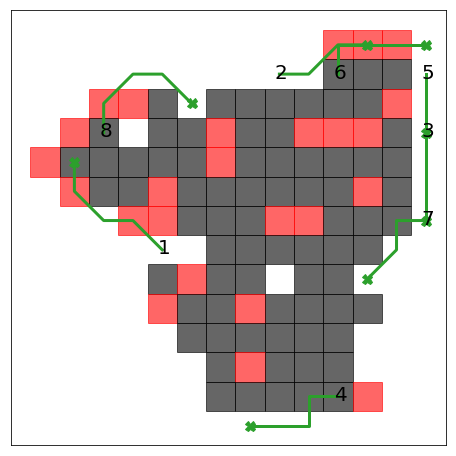

In [106]:
tic = time.clock()

# intialize simulator
s = seed
sim = FireSimulator(grid_size, rng=s)
sim.step([]) # start fire in domain

# for _ in range(3):
#     sim.step([])

# initialize agent position
n = num_agents
agent_pos = np.random.choice(spawn_loc, (n,2)) + np.random.choice(perturbs, (n,2))
agent_pos = np.squeeze(agent_pos).astype(np.int32)
agent_data = {}
plot_pos = {}
for k in range(n):
    agent_data[k] = {}
    agent_data[k]['sf'] = False
    plot_pos[k] = {}
    plot_pos[k]['x'] = []
    plot_pos[k]['x'].append(agent_pos[k,0])
    plot_pos[k]['y'] = []
    plot_pos[k]['y'].append(agent_pos[k,1])
    
control = []
repeat_ctr = 1

new_agent_pos = np.zeros((n,2)).astype(np.int32)

# while not sim.end:
steps = 6*10
for _ in range(steps):

    # calculate action for each agent
    for k in range(n):
        img, img_st, _ = CreateImageBW(sim.state, agent_pos[k,:])
        if img_st[8//2,8//2] in [1,2]:
            agent_data[k]['sf'] = True                

        rot_vec = agent_pos[k,:] - center
        rot_vec = rot_vec / np.linalg.norm(rot_vec,2)
        rot_vec = np.array([rot_vec[1],-rot_vec[0]])

        dists = [(np.linalg.norm(agent_pos[k,:]-p,2),j,p) for j,p in enumerate(agent_pos) if j!=k]
        min_dist, min_id, min_pos = min(dists)

        pos_vec = agent_pos[k,:] - min_pos
        if pos_vec[0]!=0 and pos_vec[1]!= 0:
            pos_vec = pos_vec / np.linalg.norm(pos_vec,2)

        state = np.concatenate((img[3:6,3:6].reshape((img_dim**2,)), rot_vec, 
                                np.asarray(k>min_id)[np.newaxis], pos_vec))
        

        if not agent_data[k]['sf']:
            #action = np.random.choice(range(9))
            #traj = actions_to_trajectory(agent_pos, [action])

            traj, action, agent_data[k]['sf'] = heuristic(k, agent_pos[k,:], img_st, 
                                                          agent_data[k]['sf'], center, min_id, min_pos)
            action = action[0]

        else:
            state = Variable(torch.from_numpy(state)).type(dtype)
            Q = model(state.unsqueeze(0))[0].data.cpu().numpy()
            action = np.argmax(Q)
            traj = actions_to_trajectory(agent_pos[k,:], [action])

        # generate control from trajectory
        control.extend(FindGridIntersections(sim.state, traj)) 
        control = list(set(control))

        # update agent location
        new_agent_pos[k,:] = [traj[-1][0], traj[-1][1]]  
        plot_pos[k]['x'].append(new_agent_pos[k,0])
        plot_pos[k]['y'].append(new_agent_pos[k,1])

    # update simulator periodically 
    if repeat_ctr % repeat_lim == 0:
        sim.step(control, dbeta=dp)
        control = []
        #for k in range(n):
        #    plot_pos[k]['x'] = []
        #    plot_pos[k]['y'] = []
    repeat_ctr += 1

    # update agent position
    agent_pos = new_agent_pos
    new_agent_pos = np.zeros((n,2)).astype(np.int32)

    if sim.end:
        print('process terminated')
        break

toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
#plt.xlim([0,grid_size+1])
#plt.ylim([0,grid_size+1])
#plt.title('iteration: %d, action: %d' % (sim.iter,repeat_ctr))
plt.tick_params(axis='both',which='both',
                labelbottom='off',labelleft='off',
                bottom='off',left='off')
#plt.axis('off')

for i in range(grid_size):
    for j in range(grid_size):
        x = 2*col_to_x(j)
        y = 2*row_to_y(grid_size,i)

        #if sim.state[i,j] == 0:
        #    rect = patches.Rectangle((x-0.5,y-0.5),1,1,alpha=0.6,color='g')
        #    ax.add_patch(rect)
        if sim.state[i,j] == 1:
            rect = patches.Rectangle((x-1,y-1),2,2,alpha=0.6,color='r')
            ax.add_patch(rect)
        elif sim.state[i,j] == 2:
            rect = patches.Rectangle((x-1,y-1),2,2,alpha=0.6,color='k')         
            ax.add_patch(rect)
    
corr = -0.3
for k in range(n):
    #plt.plot(2*plot_pos[k]['x'][-repeat_lim], 2*plot_pos[k]['y'][-repeat_lim], 'C2o', markersize=10)
    plt.plot(2*plot_pos[k]['x'][-1], 2*plot_pos[k]['y'][-1], 'C2X', markersize=10)
    plt.plot([2*plot_pos[k]['x'][-j] for j in range(repeat_lim+1,0,-1)], 
             [2*plot_pos[k]['y'][-j] for j in range(repeat_lim+1,0,-1)], 'C2-', linewidth=3)
    ax.annotate(str(k+1), xy=(2*plot_pos[k]['x'][-repeat_lim-1]+corr, 2*plot_pos[k]['y'][-repeat_lim-1]+corr), 
                color='k', size=20)
    
    
# plt.savefig('sample_path.pdf', dpi=300, bbox_inches='tight')

### Code to compare heuristic and network actions

In [201]:
seed = 50

grid_size = 50
num_agents = 4
repeat_lim = 4

center = (grid_size+1)/2
spawn_loc = np.arange(grid_size//3//2,grid_size,grid_size//3)
perturbs = np.arange(-grid_size//3//2+1,grid_size//3//2+1,1)

0.33s = 0.01m elapsed


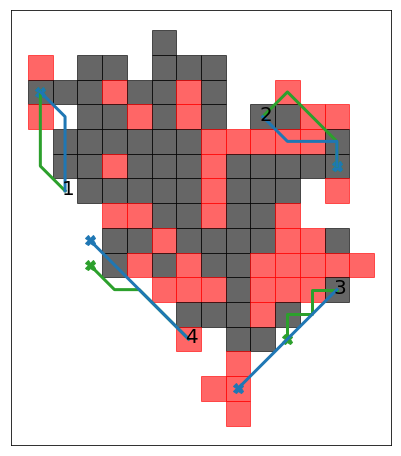

In [205]:
tic = time.clock()

# intialize simulator
s = seed
sim = FireSimulator(grid_size, rng=s)
sim.step([]) # start fire in domain

# for _ in range(3):
#     sim.step([])

# initialize agent position
n = num_agents
agent_pos = np.random.choice(spawn_loc, (n,2)) + np.random.choice(perturbs, (n,2))
agent_pos = np.squeeze(agent_pos).astype(np.int32)

agent_data = {}
plot_net = {}
plot_hrt = {}
plot_hrt[sim.iter] = {}
for k in range(n):
    agent_data[k] = {}
    agent_data[k]['sf'] = False
    
    plot_net[k] = {}
    plot_net[k]['x'] = []
    plot_net[k]['x'].append(agent_pos[k,0])
    plot_net[k]['y'] = []
    plot_net[k]['y'].append(agent_pos[k,1])
    
    plot_hrt[sim.iter][k] = {}
    plot_hrt[sim.iter][k]['x'] = []
    plot_hrt[sim.iter][k]['x'].append(agent_pos[k,0])
    plot_hrt[sim.iter][k]['y'] = []
    plot_hrt[sim.iter][k]['y'].append(agent_pos[k,1])
    
control = []
repeat_ctr = 1

new_agent_pos = np.zeros((n,2)).astype(np.int32)

# while not sim.end:
steps = 4*15

for _ in range(steps):

    # calculate action for each agent
    for k in range(n):
        img, img_st, _ = CreateImageBW(sim.state, agent_pos[k,:])
        if img_st[8//2,8//2] in [1,2]:
            agent_data[k]['sf'] = True                

        rot_vec = agent_pos[k,:] - center
        rot_vec = rot_vec / np.linalg.norm(rot_vec,2)
        rot_vec = np.array([rot_vec[1],-rot_vec[0]])

        dists = [(np.linalg.norm(agent_pos[k,:]-p,2),j,p) for j,p in enumerate(agent_pos) if j!=k]
        min_dist, min_id, min_pos = min(dists)

        pos_vec = agent_pos[k,:] - min_pos
        if pos_vec[0]!=0 and pos_vec[1]!= 0:
            pos_vec = pos_vec / np.linalg.norm(pos_vec,2)

        state = np.concatenate((img[3:6,3:6].reshape((img_dim**2,)), rot_vec, 
                                np.asarray(k>min_id)[np.newaxis], pos_vec))
        
        if not agent_data[k]['sf']:
            #action = np.random.choice(range(9))
            #traj = actions_to_trajectory(agent_pos, [action])

            traj, action, agent_data[k]['sf'] = heuristic(k, agent_pos[k,:], img_st, 
                                                          agent_data[k]['sf'], center, min_id, min_pos)
            action = action[0]
            hrt_traj = traj

        else:
            state = Variable(torch.from_numpy(state)).type(dtype)
            Q = model(state.unsqueeze(0))[0].data.cpu().numpy()
            action = np.argmax(Q)
            traj = actions_to_trajectory(agent_pos[k,:], [action])
            
            hrt_pos = np.array([plot_hrt[sim.iter][k]['x'][-1], plot_hrt[sim.iter][k]['y'][-1]])
            img, img_st, _ = CreateImageBW(sim.state, hrt_pos)
            dists = [(np.linalg.norm(hrt_pos-p,2),j,p) for j,p in enumerate(agent_pos) if j!=k]
            min_dist, min_id, min_pos = min(dists)
            hrt_traj, _, _ = heuristic(k, hrt_pos, img_st, 
                                       agent_data[k]['sf'], center, min_id, min_pos)

        plot_hrt[sim.iter][k]['x'].append(hrt_traj[-1][0])
        plot_hrt[sim.iter][k]['y'].append(hrt_traj[-1][1])
        plot_net[k]['x'].append(traj[-1][0])
        plot_net[k]['y'].append(traj[-1][1])
            
        # generate control from trajectory
        control.extend(FindGridIntersections(sim.state, traj)) 
        control = list(set(control))

        # update agent location
        new_agent_pos[k,:] = [traj[-1][0], traj[-1][1]]  

    # update simulator periodically 
    if repeat_ctr % repeat_lim == 0:
        sim.step(control, dbeta=dp)
        control = []
        
        plot_hrt[sim.iter] = {}
        for k in range(num_agents):
            plot_hrt[sim.iter][k] = {}
            plot_hrt[sim.iter][k]['x'] = []
            plot_hrt[sim.iter][k]['x'].append(new_agent_pos[k,0])
            plot_hrt[sim.iter][k]['y'] = []
            plot_hrt[sim.iter][k]['y'].append(new_agent_pos[k,1])

    repeat_ctr += 1

    # update agent position
    agent_pos = new_agent_pos
    new_agent_pos = np.zeros((n,2)).astype(np.int32)

    if sim.end:
        print('process terminated')
        break

toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
#plt.xlim([0,grid_size+1])
#plt.ylim([0,grid_size+1])
#plt.title('iteration: %d, action: %d' % (sim.iter,repeat_ctr))
plt.tick_params(axis='both',which='both',
                labelbottom='off',labelleft='off',
                bottom='off',left='off')
#plt.axis('off')

for i in range(grid_size):
    for j in range(grid_size):
        x = 2*col_to_x(j)
        y = 2*row_to_y(grid_size,i)

        #if sim.state[i,j] == 0:
        #    rect = patches.Rectangle((x-0.5,y-0.5),1,1,alpha=0.6,color='g')
        #    ax.add_patch(rect)
        if sim.state[i,j] == 1:
            rect = patches.Rectangle((x-1,y-1),2,2,alpha=0.6,color='r')
            ax.add_patch(rect)
        elif sim.state[i,j] == 2:
            rect = patches.Rectangle((x-1,y-1),2,2,alpha=0.6,color='k')         
            ax.add_patch(rect)
    
corr = -0.3
for k in range(num_agents):
    #plt.plot(2*plot_net[k]['x'][-repeat_lim], 2*plot_net[k]['y'][-repeat_lim], 'C2o', markersize=10)
    plt.plot(2*plot_net[k]['x'][-1], 2*plot_net[k]['y'][-1], 'C2X', markersize=10)
    plt.plot(2*plot_hrt[sim.iter-1][k]['x'][-1], 2*plot_hrt[sim.iter-1][k]['y'][-1], 'C0X', markersize=10)
    plt.plot([2*plot_net[k]['x'][-j] for j in range(repeat_lim+1,0,-1)], 
             [2*plot_net[k]['y'][-j] for j in range(repeat_lim+1,0,-1)], 'C2-', linewidth=3)
    plt.plot([2*plot_hrt[sim.iter-1][k]['x'][-j] for j in range(repeat_lim+1,0,-1)], 
             [2*plot_hrt[sim.iter-1][k]['y'][-j] for j in range(repeat_lim+1,0,-1)], 'C0-', linewidth=3)
    ax.annotate(str(k+1), xy=(2*plot_net[k]['x'][-repeat_lim-1]+corr, 2*plot_net[k]['y'][-repeat_lim-1]+corr), 
                color='k', size=20)
    
plt.savefig('net_vs_heuristic.pdf', dpi=300, bbox_inches='tight')

## Benchmark network solution 

In [17]:
results = []

In [18]:
grid_size = 50
num_agents = 50

center = (grid_size+1)/2
spawn_loc = np.arange(grid_size//3//2,grid_size,grid_size//3)
perturbs = np.arange(-grid_size//3//2+1,grid_size//3//2+1,1)

seeds = range(100)

In [26]:
tic = time.clock()
for i,s in enumerate(seeds):
    np.random.seed(1000+s)

    # initialize simulator
    sim = FireSimulator(grid_size, rng=s)
    sim.step([]) # start fire in domain
    num_init_fires = len(sim.step([]))

    # initialize agent position
    n = num_agents
    agent_pos = np.random.choice(spawn_loc, (n,2)) + np.random.choice(perturbs, (n,2))
    agent_pos = np.squeeze(agent_pos).astype(np.int32)
    agent_data = {}
    for k in range(n):
        agent_data[k] = {}
        agent_data[k]['sf'] = False

    control = []
    repeat_ctr = 1

    new_agent_pos = np.zeros((n,2)).astype(np.int32)

    while not sim.end:
        # calculate action for each agent
        for k in range(n):
            img, img_st, _ = CreateImageBW(sim.state, agent_pos[k,:])
            if img_st[8//2,8//2] in [1,2]:
                agent_data[k]['sf'] = True                

            dists = [(np.linalg.norm(agent_pos[k,:]-p,2),j,p) for j,p in enumerate(agent_pos) if j!=k]
            min_dist, min_id, min_pos = min(dists)                
                
            if not agent_data[k]['sf']:
                #action = np.random.choice(range(9))
                #traj = actions_to_trajectory(agent_pos, [action])

                traj, action, agent_data[k]['sf'] = heuristic(k, agent_pos[k,:], img_st, 
                                                              agent_data[k]['sf'], center, min_id, min_pos)
                action = action[0]

            else:
                rot_vec = agent_pos[k,:] - center
                rot_vec = rot_vec / np.linalg.norm(rot_vec,2)
                rot_vec = np.array([rot_vec[1],-rot_vec[0]])

                pos_vec = agent_pos[k,:] - min_pos
                if pos_vec[0]!=0 and pos_vec[1]!= 0:
                    pos_vec = pos_vec / np.linalg.norm(pos_vec,2)

                state = np.concatenate((img[3:6,3:6].reshape((img_dim**2,)), rot_vec, 
                                        np.asarray(k>min_id)[np.newaxis], pos_vec))
            
                state = Variable(torch.from_numpy(state)).type(dtype)
                Q = model(state.unsqueeze(0))[0].data.cpu().numpy()
                action = np.argmax(Q)
                traj = actions_to_trajectory(agent_pos[k,:], [action])

            # generate control from trajectory
            control.extend(FindGridIntersections(sim.state, traj)) 
            control = list(set(control))

            # update agent location
            new_agent_pos[k,:] = [traj[-1][0], traj[-1][1]]

        # update simulator periodically 
        if repeat_ctr % repeat_lim == 0:
            sim.step(control, dbeta=dp)
            control = []
        repeat_ctr += 1

        # update agent position
        agent_pos = new_agent_pos
        new_agent_pos = np.zeros((n,2)).astype(np.int32)

    if (i+1) % 10 == 0:
        print("finished %d simulations" % (i+1))
    
    # store simulation result
    results.append(sim.stats[2]/np.sum(sim.stats)) # fraction of burned trees

toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

KeyboardInterrupt: 

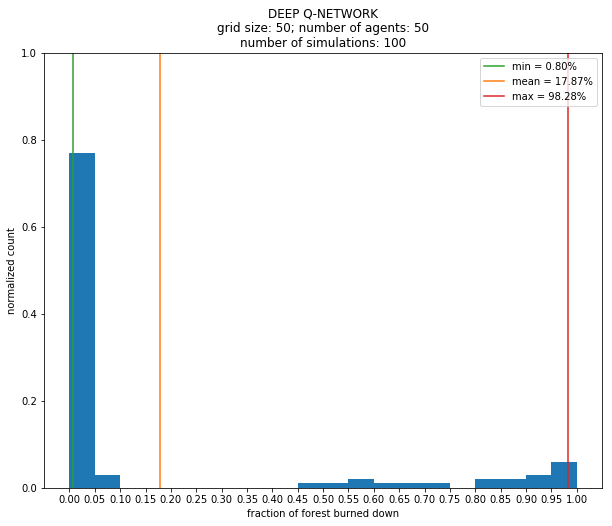

In [20]:
plt.figure()
weights = np.ones_like(results)/float(len(results))
splits, _, _ = plt.hist(results, bins=np.arange(0,1+0.05,0.05), normed=False, weights=weights)
plt.axvline(np.amin(results),color="C2",label="min = %0.2f%%" % (np.amin(results)*100))
plt.axvline(np.mean(results),color="C1",label="mean = %0.2f%%" %(np.mean(results)*100))
plt.axvline(np.amax(results),color="C3",label="max = %0.2f%%" %(np.amax(results)*100))

plt.ylim([0,1])
plt.xticks(np.arange(0,1+0.05,0.05))
plt.xlabel('fraction of forest burned down')
plt.ylabel('normalized count')
plt.title('DEEP Q-NETWORK\ngrid size: %d; number of agents: %d\nnumber of simulations: %d' %(grid_size,n,len(results)))
plt.legend(loc=1)

# plt.savefig('network_guided (110-1000).png', bbox_inches='tight')

In [21]:
splits

array([ 0.77,  0.03,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.01,  0.01,  0.02,  0.01,  0.01,  0.01,  0.  ,  0.02,  0.02,
        0.03,  0.06])

In [22]:
np.mean(results)

0.17867999999999998

In [117]:
with open('simple_ext_%d+%d+%d.pkl' %(grid_size,num_agents,num_init_fires,len(seeds)), 'wb') as fp:
    pickle.dump(results, fp)

In [24]:
win_results = [x for x in results if x <= np.mean(results)]
print('fraction of wins: %0.2f' % (100.0*len(win_results)/len(results)))
print('win mean: %0.2f' %(np.mean(win_results)*100))

fraction of wins: 80.00
win mean: 2.21


In [25]:
spawn_loc

array([ 8, 24, 40])